## Conclusion

The Pearson correlation coefficient test results indicate the strength and significance of the relationships between different variables. In this analysis:

- **The strongest correlation is observed between Palace and Metropolitan examinations, with a correlation coefficient of 0.182584, indicating a moderate positive correlation. This correlation is highly statistically significant with a p-value of 3.097262e-101.**

- The correlation coefficient between Metropolitan and Provincial examinations is 0.075779, suggesting a weak positive correlation, which is statistically significant with a p-value of 1.326249e-18.
  
- The correlation coefficient between Palace and Provincial examinations is 0.043199, indicating a similarly weak positive correlation, also statistically significant with a p-value of 5.340735e-07.



| Relationship            | Correlation Coefficient | p-value            |
|-------------------------|-------------------------|--------------------|
| Metropolitan vs Provincial | 0.075779                | 1.326249e-18       |
| Palace vs Provincial       | 0.043199                | 5.340735e-07       |
| Palace vs Metropolitan     | 0.182584                | 3.097262e-101      |


In [58]:
import pandas as pd
import matplotlib.pyplot as plt

## Read the source data

In [23]:
input_data_df = pd.read_excel('ming_jinshilu_52y_release.xlsx', sheet_name='Ming Jinshi Lists')

# only keep ID_MING_JINSHI, CBDB_personid, 姓名, 甲次, 名次, 鄉試名次, 會試名次, 進士年份
input_data_df = input_data_df[['ID_MING_JINSHI', 'CBDB_personid', '姓名', '甲次', '名次', '鄉試名次', '會試名次', '進士年份']]

# rename columns to 'ID_MING_JINSHI', 'personid', 'name', 'p_rank_1', 'p_rank_2', p_rank', 'm_rank'
input_data_df.columns = ['ID_MING_JINSHI', 'personid', 'name', 'pl_rank_1', 'pl_rank_2', 'pr_rank', 'me_rank', 'entry_year']

print(input_data_df.shape)

input_data_df.head()

(14116, 8)


,ID_MING_JINSHI,personid,name,pl_rank_1,pl_rank_2,pr_rank,me_rank,entry_year
0,JINSHI_1-120.csv_1,34414,吳伯宗,第一甲,第一名,第一名,第二十四名,1371
1,JINSHI_1-120.csv_2,198025,郭翀,第一甲,第二名,第八名,第五十一名,1371
2,JINSHI_1-120.csv_3,198026,吳公達,第一甲,第三名,第二十九名,第一百十五名,1371
3,JINSHI_1-120.csv_4,66504,楊自立,第二甲,第一名,第八名,第三名,1371
4,JINSHI_1-120.csv_5,198027,趙友能,第二甲,第二名,第二十八名,第七十三名,1371


## Create arabic numbers Chinese mapping for pa, pr, and me ranks

### Create 甲次 jiaci mapping

In [24]:
# Find unique values in pl_rank_1
jiaci_unique = input_data_df['pl_rank_1'].unique()
print(jiaci_unique)

# Create a dictionary to map the jiaci to a number
jiaci_dict = {'第一甲': 1, '第二甲': 2, '第三甲': 3, '第仕至二甲': 2, '第乙未殿試二甲': 2}

['第一甲' '第二甲' '第三甲' nan '第仕至二甲' '第乙未殿試二甲']


### Create 名次 mingci mapping

In [25]:
# Combine pl_rank_2, pr_rank, me_rank together, keep the unique values
rank_unique = input_data_df[['pl_rank_2', 'pr_rank', 'me_rank']].stack().unique()
# save the unique values to a txt file
with open('rank_unique.txt', 'w') as f:
    for item in rank_unique:
        f.write("%s\n" % item)
print(rank_unique.shape)
rank_unique[:10]

(3297,)


array(['第一名', '第二十四名', '第二名', '第八名', '第五十一名', '第三名', '第二十九名', '第一百十五名',
       '第二十八名', '第七十三名'], dtype=object)

In [26]:
rank_unique_cleaned = []
# In rank_unique
# 1. Use regex to remove "^.*試" and ^.*第 from the string
# 2. Remove "　" and " " from the string
# 3. Skip the string if it contains "□"
# 4. Remove 名
# 5. If there is no 一二三四五六七八九十百 in the string, skip the string
import re
for rank in rank_unique:
    # specific rules
    rank = rank.replace('一百三十五名未廷試', '一百三十五')
    rank = rank.replace('叄', '三')
    rank = rank.replace('、', '')
    rank = rank.replace('士一', '十一')
    rank = re.sub('台$', '', rank)

    # general rules
    rank = re.sub('^.*試', '', rank)
    rank = re.sub('^.*第', '', rank)
    rank = rank.replace('　', '')
    rank = rank.replace(' ', '')
    rank = rank.replace('名', '')
    if '□' in rank:
        rank = ''
    if not re.search('[一二三四五六七八九十百]', rank) and rank != '':
        # rank = "no_number"
        rank = ""
    rank_unique_cleaned.append(rank)

# save rank_unique and rank_unique_cleaned to two columns in a csv file
rank_unique_df = pd.DataFrame({'rank_unique': rank_unique, 'rank_unique_cleaned': rank_unique_cleaned})
rank_unique_df.to_csv('rank_unique.csv', index=False, encoding='utf-8-sig')
rank_unique_df.head()

,rank_unique,rank_unique_cleaned
0,第一名,一
1,第二十四名,二十四
2,第二名,二
3,第八名,八
4,第五十一名,五十一


In [27]:
# Print the unique number of rank_unique_cleaned
rank_unique_cleaned_unique = list(set(rank_unique_cleaned))
# Remove the empty string
rank_unique_cleaned_unique.remove('')
print(len(rank_unique_cleaned_unique))
# save the unique values to a txt file
with open('rank_unique_cleaned_unique.txt', 'w') as f:
    for item in rank_unique_cleaned_unique:
        f.write("%s\n" % item)


467


## Create number column for input_data_df

In [28]:
number_mapping_df = pd.read_excel('number_mapping_from_llm.xlsx', sheet_name='data')
number_mapping_df.head()

# Create a dictionary to map the rank to a number
rank_dict = {}
for index, row in number_mapping_df.iterrows():
    rank_dict[row['rank']] = row['number']

# Add number columns to the rank_unique_df
rank_unique_df['number'] = rank_unique_df['rank_unique_cleaned'].map(rank_dict)

# Create a dictionary to map the rank_unique to a number
rank_unique_dict = {}
for index, row in rank_unique_df.iterrows():
    rank_unique_dict[row['rank_unique']] = row['number']

for key in list(rank_unique_dict.keys())[:10]:
    print(key, rank_unique_dict[key])

第一名 1.0
第二十四名 24.0
第二名 2.0
第八名 8.0
第五十一名 51.0
第三名 3.0
第二十九名 29.0
第一百十五名 115.0
第二十八名 28.0
第七十三名 73.0
 1.0
第二十四名 24.0
第二名 2.0
第八名 8.0
第五十一名 51.0
第三名 3.0
第二十九名 29.0
第一百十五名 115.0
第二十八名 28.0
第七十三名 73.0


In [29]:
# Add number columns to the input_data_df
input_data_df['pl_rank_1_number'] = input_data_df['pl_rank_1'].map(jiaci_dict)
input_data_df['pl_rank_2_number'] = input_data_df['pl_rank_2'].map(rank_unique_dict)
input_data_df['pr_rank_number'] = input_data_df['pr_rank'].map(rank_unique_dict)
input_data_df['me_rank_number'] = input_data_df['me_rank'].map(rank_unique_dict)

input_data_df.head()

,ID_MING_JINSHI,personid,name,pl_rank_1,pl_rank_2,pr_rank,me_rank,entry_year,pl_rank_1_number,pl_rank_2_number,pr_rank_number,me_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,第一甲,第一名,第一名,第二十四名,1371,1.0,1.0,1.0,24.0
1,JINSHI_1-120.csv_2,198025,郭翀,第一甲,第二名,第八名,第五十一名,1371,1.0,2.0,8.0,51.0
2,JINSHI_1-120.csv_3,198026,吳公達,第一甲,第三名,第二十九名,第一百十五名,1371,1.0,3.0,29.0,115.0
3,JINSHI_1-120.csv_4,66504,楊自立,第二甲,第一名,第八名,第三名,1371,2.0,1.0,8.0,3.0
4,JINSHI_1-120.csv_5,198027,趙友能,第二甲,第二名,第二十八名,第七十三名,1371,2.0,2.0,28.0,73.0


In [30]:
# Create pl_rank by combining pl_rank_1_number as integer, and pl_rank_2_number as decimal
input_data_df['pl_rank_number'] = input_data_df['pl_rank_1_number'] + input_data_df['pl_rank_2_number'] / 1000

input_data_df.head()

,ID_MING_JINSHI,personid,name,pl_rank_1,pl_rank_2,pr_rank,me_rank,entry_year,pl_rank_1_number,pl_rank_2_number,pr_rank_number,me_rank_number,pl_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,第一甲,第一名,第一名,第二十四名,1371,1.0,1.0,1.0,24.0,1.001
1,JINSHI_1-120.csv_2,198025,郭翀,第一甲,第二名,第八名,第五十一名,1371,1.0,2.0,8.0,51.0,1.002
2,JINSHI_1-120.csv_3,198026,吳公達,第一甲,第三名,第二十九名,第一百十五名,1371,1.0,3.0,29.0,115.0,1.003
3,JINSHI_1-120.csv_4,66504,楊自立,第二甲,第一名,第八名,第三名,1371,2.0,1.0,8.0,3.0,2.001
4,JINSHI_1-120.csv_5,198027,趙友能,第二甲,第二名,第二十八名,第七十三名,1371,2.0,2.0,28.0,73.0,2.002


## Clean data for correlation calculation

In [31]:
# Drop 'pl_rank_1', 'pl_rank_2', 'pr_rank', 'me_rank', 'pl_rank_1_number', 'pl_rank_2_number'
input_data_df = input_data_df.drop(columns=['pl_rank_1', 'pl_rank_2', 'pr_rank', 'me_rank', 'pl_rank_1_number', 'pl_rank_2_number'])
# Delete the rows if any values in pr_rank_number	me_rank_number	pl_rank_number are empty
input_data_df = input_data_df.dropna(subset=['pr_rank_number', 'me_rank_number', 'pl_rank_number'])

print(input_data_df.shape)
input_data_df.head()

(13460, 7)


,ID_MING_JINSHI,personid,name,entry_year,pr_rank_number,me_rank_number,pl_rank_number
0,JINSHI_1-120.csv_1,34414,吳伯宗,1371,1.0,24.0,1.001
1,JINSHI_1-120.csv_2,198025,郭翀,1371,8.0,51.0,1.002
2,JINSHI_1-120.csv_3,198026,吳公達,1371,29.0,115.0,1.003
3,JINSHI_1-120.csv_4,66504,楊自立,1371,8.0,3.0,2.001
4,JINSHI_1-120.csv_5,198027,趙友能,1371,28.0,73.0,2.002


# Calculate pearsonr for pr_rank_number	me_rank_number	pl_rank_number

In [32]:
from scipy.stats import pearsonr
pr_rank_number = input_data_df['pr_rank_number']
me_rank_number = input_data_df['me_rank_number']
pl_rank_number = input_data_df['pl_rank_number']
pearsonr_me_pr = pearsonr(me_rank_number, pr_rank_number)
pearsonr_pl_pr = pearsonr(pl_rank_number, pr_rank_number)
pearsonr_pl_me = pearsonr(pl_rank_number, me_rank_number)

# calculate the correlation coefficient between pr_rank_number and me_rank_number
index_names = ['metropolitan_provincial', 'palace_provincial', 'palace_metropolitan']
correlation_coefficient = [pearsonr_me_pr[0], pearsonr_pl_pr[0], pearsonr_pl_me[0]]
correlation_p_value = [pearsonr_me_pr[1], pearsonr_pl_pr[1], pearsonr_pl_me[1]]
correlation_df = pd.DataFrame({'correlation_coefficient': correlation_coefficient, 'p_value': correlation_p_value}, index=index_names)

correlation_df

,correlation_coefficient,p_value
metropolitan_provincial,0.075779,1.326249e-18
palace_provincial,0.043199,5.340735e-07
palace_metropolitan,0.182584,3.097262e-101


## The number one in me, the histogram of the pr ranks

<AxesSubplot:>

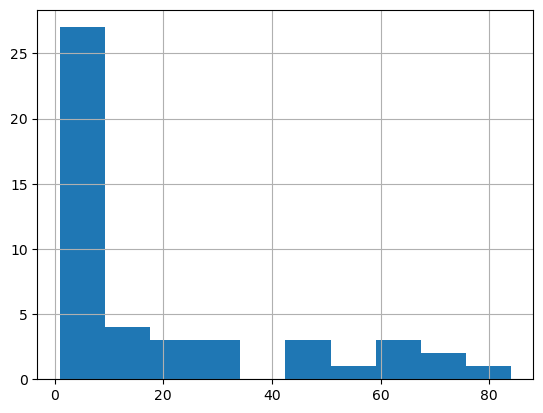

In [33]:
# When me_rank_number = 1.0, the distribution the pr_rank_number
input_data_df_me_rank_1 = input_data_df[input_data_df['me_rank_number'] == 1.0]
input_data_df_me_rank_1['pr_rank_number'].hist()

In [34]:
# Calculate the rate of pr_rank_number < 10 and pr_rank_number >= 10
pr_rank_number_lt_10 = input_data_df_me_rank_1[input_data_df_me_rank_1['pr_rank_number'] < 10].shape[0]
pr_rank_number_ge_10 = input_data_df_me_rank_1[input_data_df_me_rank_1['pr_rank_number'] >= 10].shape[0]
pr_rank_number_lt_10_rate = pr_rank_number_lt_10 / (pr_rank_number_lt_10 + pr_rank_number_ge_10)
pr_rank_number_ge_10_rate = pr_rank_number_ge_10 / (pr_rank_number_lt_10 + pr_rank_number_ge_10)

pr_rank_number_lt_10_rate, pr_rank_number_ge_10_rate

(0.574468085106383, 0.425531914893617)

<AxesSubplot:>

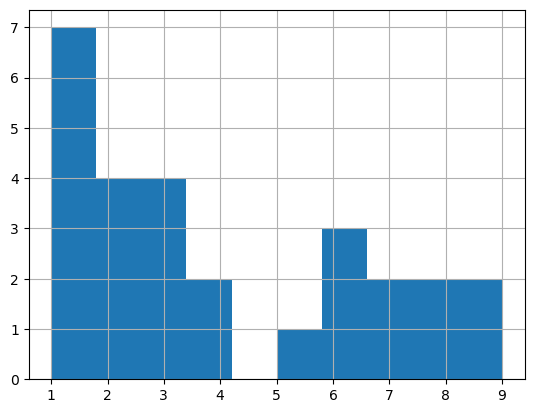

In [35]:
# Only keep the rows with pr_rank_number <= 10
input_data_df_me_rank_1_pr_less_than_10 = input_data_df_me_rank_1[input_data_df_me_rank_1['pr_rank_number'] <= 10]
input_data_df_me_rank_1_pr_less_than_10['pr_rank_number'].hist()

## The number one in pr, the histogram of the me ranks

<AxesSubplot:>

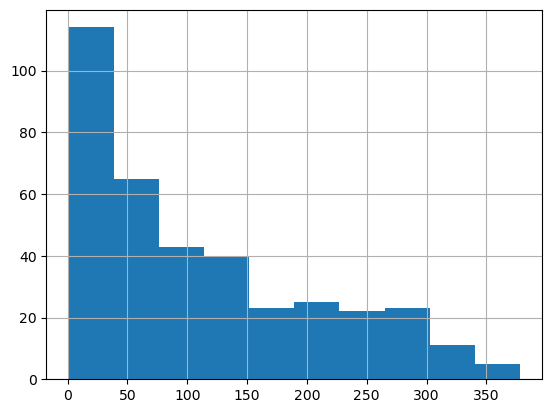

In [36]:
# Draw the number on in pr, the Histogram of the me ranks
input_data_df_pr_rank_1 = input_data_df[input_data_df['pr_rank_number'] == 1.0]
input_data_df_pr_rank_1['me_rank_number'].hist()

In [37]:
# Calculate the rate of pm_rank_number < 10 and pm_rank_number >= 10
me_rank_number_lt_10 = input_data_df_pr_rank_1[input_data_df_pr_rank_1['me_rank_number'] < 10].shape[0]
me_rank_number_ge_10 = input_data_df_pr_rank_1[input_data_df_pr_rank_1['me_rank_number'] >= 10].shape[0]
me_rank_number_lt_10_rate = me_rank_number_lt_10 / (me_rank_number_lt_10 + me_rank_number_ge_10)
me_rank_number_ge_10_rate = me_rank_number_ge_10 / (me_rank_number_lt_10 + me_rank_number_ge_10)

me_rank_number_lt_10_rate, me_rank_number_ge_10_rate

(0.09703504043126684, 0.9029649595687331)

<AxesSubplot:>

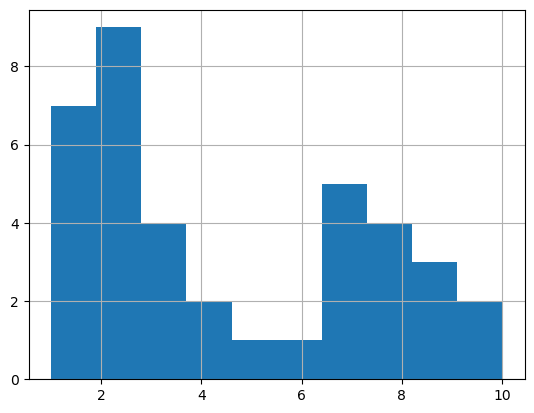

In [38]:
# Only keep the rows with me_rank_number <= 10 AKA 會試第一名在進士名次前十名的比例
input_data_df_pr_rank_1_me_less_than_10 = input_data_df_pr_rank_1[input_data_df_pr_rank_1['me_rank_number'] <= 10]
input_data_df_pr_rank_1_me_less_than_10['me_rank_number'].hist()

## Top 1%, 5%, 10% in me, the Histogram of the pr ranks

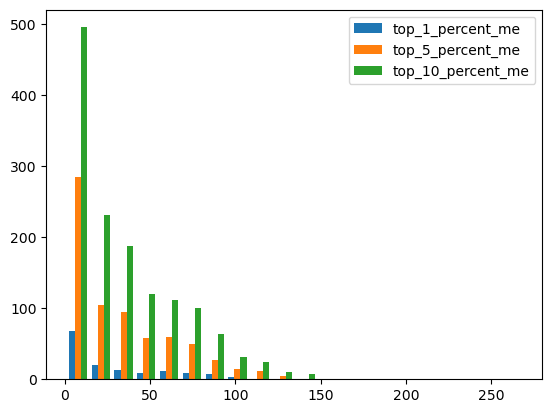

In [60]:
## Top 1%, 5%, 10% in me, the Histogram of the pr ranks
top_1_percent_me = input_data_df[input_data_df['me_rank_number'] <= input_data_df['me_rank_number'].quantile(0.01)]

top_5_percent_me = input_data_df[input_data_df['me_rank_number'] <= input_data_df['me_rank_number'].quantile(0.05)]

top_10_percent_me = input_data_df[input_data_df['me_rank_number'] <= input_data_df['me_rank_number'].quantile(0.10)]

# draw the histogram of top_1_percent_me, top_5_percent_me, top_10_percent_me together
plt.hist([top_1_percent_me['pr_rank_number'],  top_5_percent_me['pr_rank_number'], top_10_percent_me['pr_rank_number']], bins=20, label=['top_1_percent_me', 'top_5_percent_me', 'top_10_percent_me'])
plt.legend(loc='upper right')
plt.show()

## Last 1%, 5%, 10% in me, the Histogram of the pr ranks

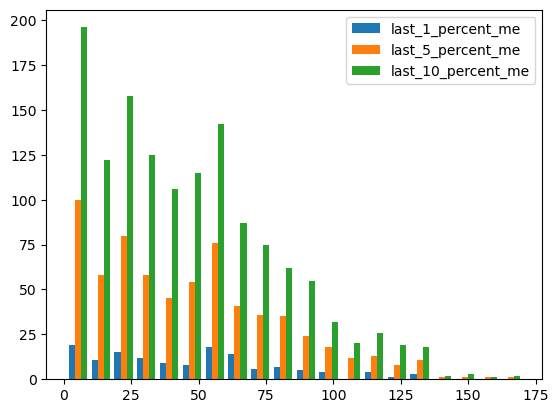

In [61]:
last_1_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.99)]

last_5_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.95)]

last_10_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.90)]

plt.hist([last_1_percent_me['pr_rank_number'],  last_5_percent_me['pr_rank_number'], last_10_percent_me['pr_rank_number']], bins=20, label=['last_1_percent_me', 'last_5_percent_me', 'last_10_percent_me'])
plt.legend(loc='upper right')
plt.show()

## Top 5% in me, the Histogram of the pr ranks

<AxesSubplot:>

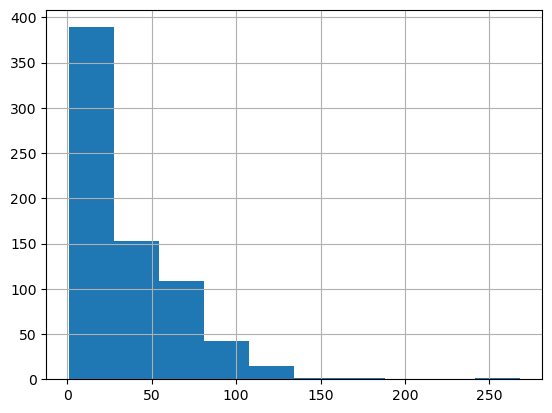

In [43]:
top_5_percent_me = input_data_df[input_data_df['me_rank_number'] <= input_data_df['me_rank_number'].quantile(0.05)]
top_5_percent_me['pr_rank_number'].hist()


## Top 10% in me, the Histogram of the pr ranks

<AxesSubplot:>

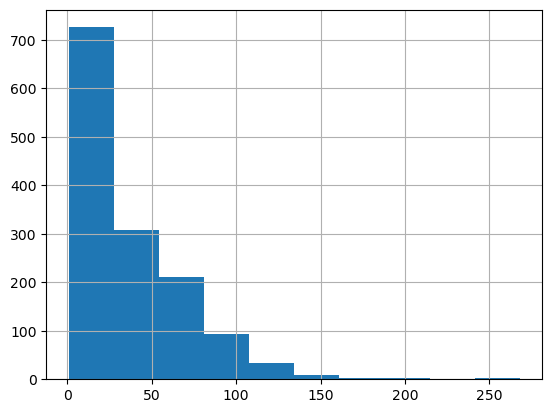

In [51]:
top_10_percent_me = input_data_df[input_data_df['me_rank_number'] <= input_data_df['me_rank_number'].quantile(0.1)]
top_10_percent_me['pr_rank_number'].hist()

## Last 1% in me, the Histogram of the pr ranks

<AxesSubplot:>

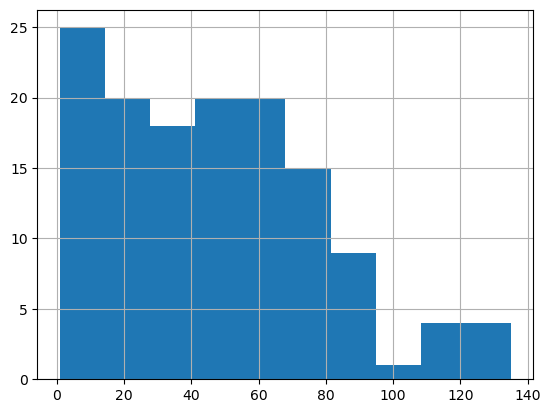

In [52]:
# Last 1% in me, the Histogram of the pr ranks
last_1_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.99)]
last_1_percent_me['pr_rank_number'].hist()

## Last 5% in me, the Histogram of the pr ranks

<AxesSubplot:>

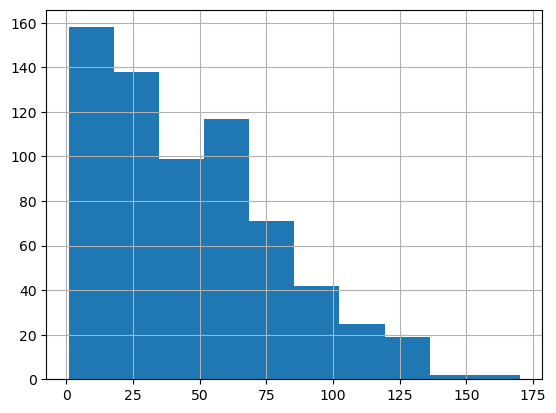

In [45]:
# Last 5% in me, the Histogram of the pr ranks
last_5_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.95)]
last_5_percent_me['pr_rank_number'].hist()

## Last 10% in me, the Histogram of the pr ranks

<AxesSubplot:>

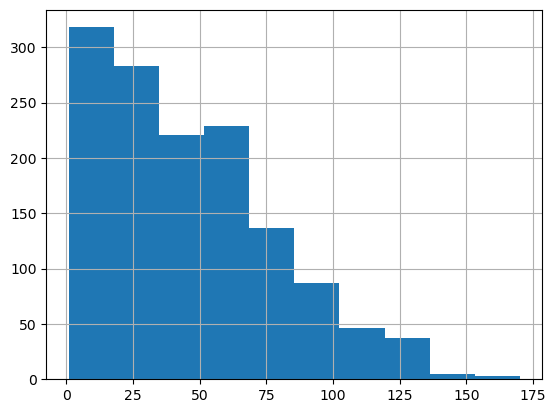

In [53]:
last_10_percent_me = input_data_df[input_data_df['me_rank_number'] >= input_data_df['me_rank_number'].quantile(0.9)]
last_10_percent_me['pr_rank_number'].hist()

## Top 1%, 5%, 10% in pr, the Histogram of the me ranks

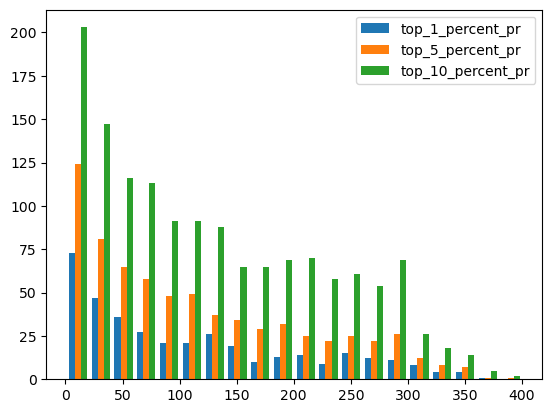

In [56]:
top_1_percent_pr = input_data_df[input_data_df['pr_rank_number'] <= input_data_df['pr_rank_number'].quantile(0.01)]

top_5_percent_pr = input_data_df[input_data_df['pr_rank_number'] <= input_data_df['pr_rank_number'].quantile(0.05)]

top_10_percent_pr = input_data_df[input_data_df['pr_rank_number'] <= input_data_df['pr_rank_number'].quantile(0.1)]

plt.hist([top_1_percent_pr['me_rank_number'], top_5_percent_pr['me_rank_number'], top_10_percent_pr['me_rank_number']], bins=20, label=['top_1_percent_pr', 'top_5_percent_pr', 'top_10_percent_pr'])
plt.legend(loc='upper right')
plt.show()



## Last 1%, 5%, 10% in pr, the Histogram of the me ranks

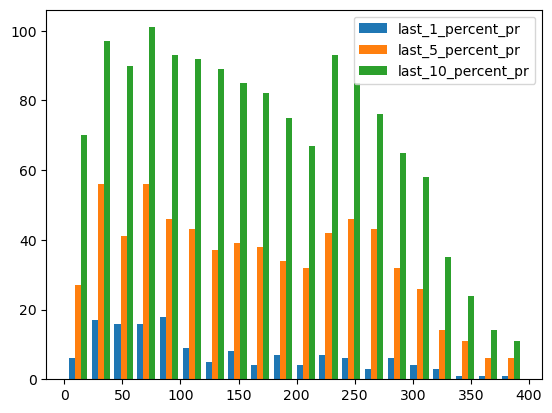

In [57]:
last_1_percent_pr = input_data_df[input_data_df['pr_rank_number'] >= input_data_df['pr_rank_number'].quantile(0.99)]

last_5_percent_pr = input_data_df[input_data_df['pr_rank_number'] >= input_data_df['pr_rank_number'].quantile(0.95)]

last_10_percent_pr = input_data_df[input_data_df['pr_rank_number'] >= input_data_df['pr_rank_number'].quantile(0.9)]

plt.hist([last_1_percent_pr['me_rank_number'], last_5_percent_pr['me_rank_number'], last_10_percent_pr['me_rank_number']], bins=20, label=['last_1_percent_pr', 'last_5_percent_pr', 'last_10_percent_pr'])
plt.legend(loc='upper right')
plt.show()

## Correlations of entry_year groups

In [39]:
year_interval = 30

# Create a new column 'entry_year_interval' by dividing 'entry_year' by year_interval and rounding down
input_data_df['entry_year_interval'] = input_data_df['entry_year'] // year_interval * year_interval
# Save input_data_df to a csv file
input_data_df.head()

,ID_MING_JINSHI,personid,name,entry_year,pr_rank_number,me_rank_number,pl_rank_number,entry_year_interval
0,JINSHI_1-120.csv_1,34414,吳伯宗,1371,1.0,24.0,1.001,1350
1,JINSHI_1-120.csv_2,198025,郭翀,1371,8.0,51.0,1.002,1350
2,JINSHI_1-120.csv_3,198026,吳公達,1371,29.0,115.0,1.003,1350
3,JINSHI_1-120.csv_4,66504,楊自立,1371,8.0,3.0,2.001,1350
4,JINSHI_1-120.csv_5,198027,趙友能,1371,28.0,73.0,2.002,1350


In [40]:
# Calcuate pearson correlation coefficient and pvalue for each year_interval
correlation_coefficient_list = []
correlation_p_value_list = []
for year in input_data_df['entry_year_interval'].unique():
    temp_df = input_data_df[input_data_df['entry_year_interval'] == year]
    pr_rank_number = temp_df['pr_rank_number']
    me_rank_number = temp_df['me_rank_number']
    pl_rank_number = temp_df['pl_rank_number']
    pearsonr_me_pr = pearsonr(me_rank_number, pr_rank_number)
    pearsonr_pl_pr = pearsonr(pl_rank_number, pr_rank_number)
    pearsonr_pl_me = pearsonr(pl_rank_number, me_rank_number)
    data_number = temp_df.shape[0]
    correlation_coefficient_list.append([pearsonr_me_pr[0], pearsonr_pl_pr[0], pearsonr_pl_me[0], data_number])
    correlation_p_value_list.append([pearsonr_me_pr[1], pearsonr_pl_pr[1], pearsonr_pl_me[1], data_number])

correlation_coefficient_df = pd.DataFrame(correlation_coefficient_list, columns=['metropolitan_provincial', 'palace_provincial', 'palace_metropolitan', "data_number"], index=input_data_df['entry_year_interval'].unique())
correlation_p_value_df = pd.DataFrame(correlation_p_value_list, columns=['metropolitan_provincial', 'palace_provincial', 'palace_metropolitan', "data_number"], index=input_data_df['entry_year_interval'].unique())

correlation_coefficient_df = correlation_coefficient_df.sort_index()
correlation_p_value_df = correlation_p_value_df.sort_index()

In [41]:
correlation_p_value_df

,metropolitan_provincial,palace_provincial,palace_metropolitan,data_number
1350,0.623879,0.642551,1.859445e-01,62
1380,0.418075,0.239680,4.099069e-03,109
1410,0.114819,0.526828,5.055697e-04,336
1440,0.000005,0.103154,8.315839e-13,2238
1470,0.003666,0.001001,3.677759e-12,2387
1500,0.000023,0.085319,1.404573e-11,1843
1530,0.000351,0.175246,1.304696e-19,3170
1560,0.000017,0.001441,1.887709e-27,3085
1590,0.417508,0.994437,3.531217e-02,230


In [42]:
correlation_coefficient_df

,metropolitan_provincial,palace_provincial,palace_metropolitan,data_number
1350,0.063505,0.060115,0.170215,62
1380,0.078345,0.113565,0.272847,109
1410,0.086188,0.034644,0.188724,336
1440,0.096151,0.034459,0.150484,2238
1470,0.059449,0.067301,0.141590,2387
1500,0.098375,0.040091,0.156540,1843
1530,0.063449,0.024082,0.159942,3170
1560,0.077319,0.057343,0.193661,3085
1590,0.053714,-0.000462,0.138867,230
